In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Đọc dữ liệu

In [85]:
btc_data = pd.read_csv('DOGE-USD.csv')
bnb_data = pd.read_csv('BNB-USD.csv')

Dữ liệu BTC-USD

In [86]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,0.002346,0.002392,0.002322,0.002392,0.002392,17364744
1,1/2/2019,0.002388,0.002458,0.002372,0.002407,0.002407,18015392
2,1/3/2019,0.002404,0.002414,0.002356,0.002360,0.002360,17619234
3,1/4/2019,0.002364,0.002397,0.002274,0.002315,0.002315,19530100
4,1/5/2019,0.002320,0.002350,0.002280,0.002319,0.002319,17148586


Dữ liệu ETH-USD

In [87]:
bnb_data.head()

,Date,Close-Exog
0,1/1/2019,6.075273
1,1/2/2019,6.188613
2,1/3/2019,5.903535
3,1/4/2019,6.065138
4,1/5/2019,6.065543


Kết hợp dữ liệu BTC và ETH

In [88]:
data = pd.merge(btc_data, bnb_data, on='Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close-Exog
0,1/1/2019,0.002346,0.002392,0.002322,0.002392,0.002392,17364744,6.075273
1,1/2/2019,0.002388,0.002458,0.002372,0.002407,0.002407,18015392,6.188613
2,1/3/2019,0.002404,0.002414,0.002356,0.002360,0.002360,17619234,5.903535
3,1/4/2019,0.002364,0.002397,0.002274,0.002315,0.002315,19530100,6.065138
4,1/5/2019,0.002320,0.002350,0.002280,0.002319,0.002319,17148586,6.065543


**Dự đoán 30 ngày cho ETH bằng ARIMA**

In [89]:
!pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
bnb_data = bnb_data[['Date', 'Close-Exog']]
bnb_data = bnb_data.dropna() # Drop missing values
# bnb_data = bnb_data.reset_index(drop=True) # Reset the index
bnb_data['Date'] = pd.to_datetime(bnb_data['Date'])
bnb_data.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(bnb_data))
test_size = int(0.3 * len(bnb_data))
val_size = len(bnb_data) - train_size - test_size

train_data = bnb_data[:train_size]
test_data = bnb_data[train_size:train_size+test_size]
val_data = bnb_data[train_size+test_size:]
print(bnb_data)

            Close-Exog
Date                  
2019-01-01    6.075273
2019-01-02    6.188613
2019-01-03    5.903535
2019-01-04    6.065138
2019-01-05    6.065543
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[1551 rows x 1 columns]


In [91]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close-Exog'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7408.002, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7489.267, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7452.095, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7461.182, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7487.778, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7427.045, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7436.328, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7409.996, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7409.997, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7446.960, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7426.639, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7433.997, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7405.328, Time=0.81 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7399.153, Time=0.88 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [92]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close-Exog'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close-Exog'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [93]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  bnb_data.index[-1]
print(last_index)
next_30_days_index_eth = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index_eth)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days_eth = np.array(next_30_days_index_eth).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days_eth = model.predict(n_periods=len(x_next_30_days_eth)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_eth)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[297.88532006 299.40236459 302.40425579 299.9957499  299.04545064
 301.17565702 300.78940578 299.53441719 300.38099504 300.84745684
 300.03897844 300.11012693 300.6246283  300.33499026 300.1181417
 300.42122169 300.42400759 300.21656973 300.31235331 300.40935649
 300.29727109 300.28456701 300.36696461 300.3367215  300.29457913
 300.33540741 3

Validation RMSE: 27.660317310698222
Testing RMSE: 135.51391232787813
Validation MAPE: 0.07740781136610221
Testing MAPE: 0.2374260058174036


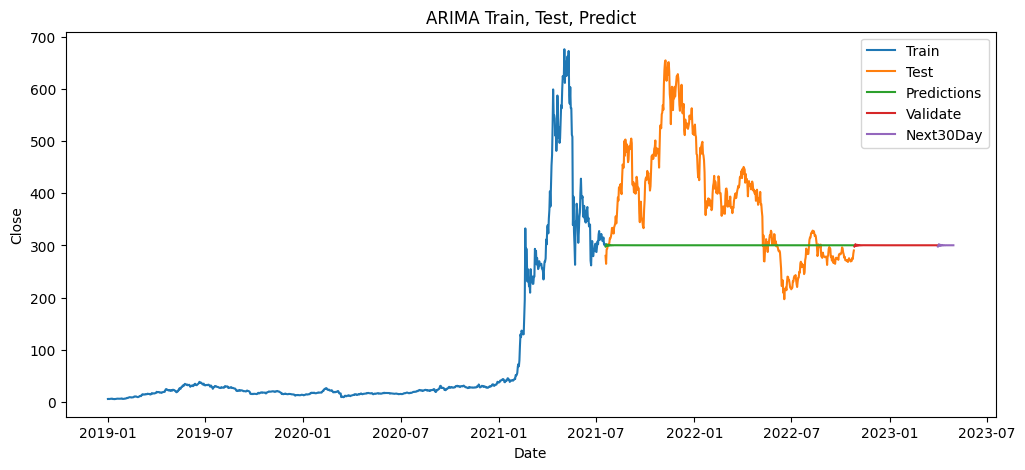

In [94]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close-Exog'])
plt.plot(test_data.index, test_data['Close-Exog'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index_eth,y_next_30_days_eth)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

**SARIMAX**

**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [95]:

# data = data.reset_index(drop=True) # Reset the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'Close-Exog']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.3 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

930
465
156


In [96]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-Exog"]]
model = auto_arima(train_data.Close, 
                   seasonal = True,
                   m=12,
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-5157.619, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-5058.268, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-5081.259, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-5083.996, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-5060.129, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-5151.868, Time=1.56 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-5147.779, Time=1.61 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-5146.359, Time=5.02 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-5162.943, Time=5.53 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-5118.848, Time=4.64 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-5142.850, Time=5.42 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-5119.734, Time=4.49 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=-5102.450, Time=4.64 sec
 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=-5120.595, Time=5.67 sec
 ARIM

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data.Close, 
 exog=train_exog,
 order=(2,1,2),
  seasonal_order=(0,0,2, 12),
 enforce_invertibility=False, enforce_stationarity=False)

c:\APP\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\APP\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [98]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exog = test_data[['Close-Exog']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exog = val_data[['Close-Exog']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2021-07-19    0.175329
2021-07-20    0.173279
2021-07-21    0.182021
2021-07-22    0.182549
2021-07-23    0.183370
                ...   
2022-10-22    0.196582
2022-10-23    0.198522
2022-10-24    0.197810
2022-10-25    0.201478
2022-10-26    0.203563
Freq: D, Name: predicted_mean, Length: 465, dtype: float64
            Close-Exog
Date                  
2022-10-27  286.844116
2022-10-28  298.014191
2022-10-29  304.217957
2022-10-30  313.754791
2022-10-31  326.360718
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[156 rows x 1 columns]
2021-07-19    0.177724
2021-07-20    0.184938
2021-07-21    0.186121
2021-07-22    0.189605
2021-07-23    0.192870
                ...   
2021-12-17    0.210781
2021-12-18    0.211592
2021-12-19    0.211796
2021-12-20    0.212752
2021-12-21    0.212918
Freq: D, Name: predicted_mean, Length: 156, dtype: float64


In [99]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)



# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = y_next_30_days_eth) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-07-19    0.181597
2021-07-20    0.185425
2021-07-21    0.185485
2021-07-22    0.184778
2021-07-23    0.183286
2021-07-24    0.188230
2021-07-25    0.191806
2021-07-26    0.190734
2021-07-27    0.195328
2021-07-28    0.197690
2021-07-29    0.197988
2021-07-30    0.197754
2021-07-31    0.199271
2021-08-01    0.200570
2021-08-02    0.199295

Validation RMSE: 0.11937809225180948
Testing RMSE: 0.1036672453766059
Validation MAPE: 1.4397780934496751
Testing MAPE: 1.002883873249817
Validation R2: -77.96982515191918
Testing R2: -0.8910409907291374


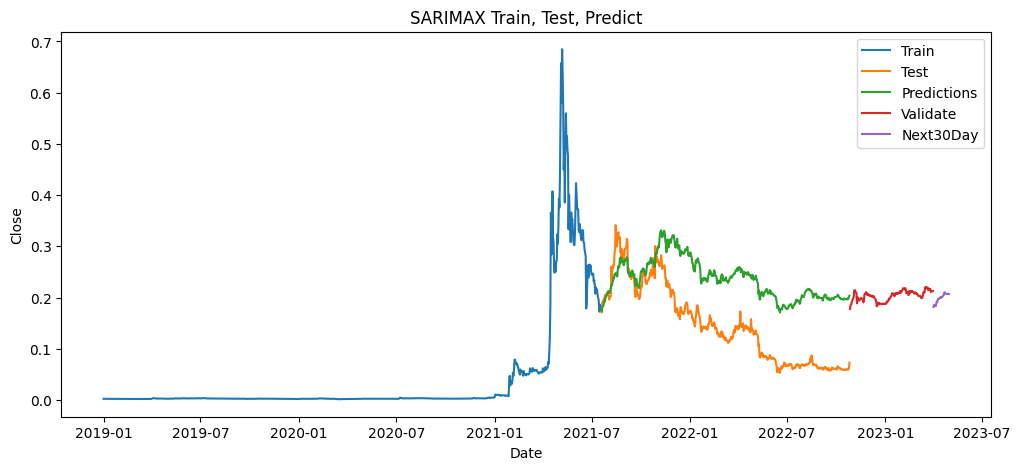

In [100]:
# 8. Tính RMSE
from sklearn.metrics import r2_score


valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred)
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation R2:', valid_r2)
print('Testing R2:', test_r2)



# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('SARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()